* Instructor: Professor Adarsh
* Description: Option A Background: Inferring parameters of a 3D line from noisy 2D images using Metropolis-Hastings MCMC
* Collabrators: TA's and Math department tutoring

--References--
* A First Course in Machine Learning
* https://youtu.be/3qZcgiTZRPA?si=3X28JvyevD1FIVHI
* https://users.ece.cmu.edu/~moura/papers/emmcvpr-jul99-aguiar-moura.pdf
* https://www.nature.com/articles/s43586-020-00001-2
* https://stats.stackexchange.com/questions/100725/what-are-some-good-references-for-the-metropolis-hastings-algorithm
* https://towardsdatascience.com/monte-carlo-markov-chain-mcmc-explained-94e3a6c8de11





## Importing Libraries 

In [115]:

from random import gauss, uniform
import numpy
import pandas as pd
import os
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt



# Global path and Loading files 

In [116]:
current_dir = os.getcwd()

data_dir = os.path.join(current_dir,'data')




# Loading CSV file
inputs = pd.read_csv(os.path.join(data_dir,'inputs.csv'))
camera1 = pd.read_csv(os.path.join(data_dir,'points_2d_camera_1.csv'))
camera2  = pd.read_csv(os.path.join(data_dir,'points_2d_camera_2.csv'))

# Extracting relevant data
x_values = inputs.to_numpy().flatten()
y_values_camera1 = camera1.to_numpy()
y_values_camera2 = camera2.to_numpy()

# Task 1 : Implementation of Metropolis-Hastings Algorithm for 3D Line Endpoint Sampling from Noisy Camera Observations

Setting up essential parameters for a 3D computer vision problem involving camera projections and posterior sampling. The camera matrix is defined, with CAMERA_1 representing the default pinhole camera matrix. prior_mean and prior_covariance establish the mean and covariance for the prior distribution of 3D points. The gaussian_cov variable defines the covariance matrix for Gaussian noise in the 2D image plane. ' N ' specifies the number of samples for the Metropolis-Hastings algorithm. These parameters collectively provide the foundational elements for subsequent tasks, including the Metropolis-Hastings sampling process for generating posterior samples of 3D points based on observed 2D points and prior information.

In [117]:

# Camera Matrix 
# Note: CAMERA_2 is commented out and CAMERA_1 is set as the default camera matrix
# CAMERA_2 = numpy.array([[0,0,1,-5], [0,1,0,0], [-1,0,0,5]])

#Camera 1 matrix
CAMERA_1 = numpy.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
CM = CAMERA_1 # Camera Matrix for projection

# Prior parameters
prior_mean = numpy.array([0, 0, 6])
prior_covariance = 6 * numpy.eye(3)  # 3x3 Identity matrix multiplied by 6

# Covariance for Gaussian noise in the 2D image plane
gaussian_cov = 0.05 ** 2 * numpy.identity(2)
N = 50 * 1000  # 50,000 samples


This function takes a camera matrix (CM), initial (pi) and final (pf) 3D points, and relative offset ratios (t).
It converts these 3D points to homogeneous coordinates, performs a perspective projection using the camera matrix, and returns the resulting 2D coordinates.

In [118]:
# Function to project 3D points to 2D using Camera 1 matrix
def camera_3d_to_2d(CM, pi, pf, t):
    pi_out = numpy.append(pi, 1)  # # Convert 3D points to homogeneous coordinates and perform the projection
    pf_out = numpy.append(pf, 1)
    camera_3d = numpy.outer(t, pf_out - pi_out) + pi_out # Outer product for line representation
    camera_2d_homog = CM @ camera_3d.T
    camera_2d = camera_2d_homog[:2] / camera_2d_homog[2]  # Convert back to 2D coordinates
    return camera_2d.T


This function calculates the likelihood of observed 2D points (r_values) given initial (pi) and final (pf) 3D points, Gaussian noise covariance (gaussian_cov), and relative offset ratios (x_values). It utilizes the camera_3d_to_2d function to project 3D points to 2D and calculates the likelihood based on a multivariate normal distribution

In [119]:
# likelihood function
def likelihood_function(CM, r_values, pi, pf, gaussian_cov, x_values):
    #Project 3D points to 2D and calculate likelihood based on multivariate normal distribution
    image = camera_3d_to_2d(CM, pi, pf, x_values)
    return sum(multivariate_normal.logpdf(r, mean=q, cov=gaussian_cov) for r, q in zip(r_values, image))


This function computes the log probability of initial (pi) and final (pf) 3D points based on a multivariate normal distribution with specified mean (prior_mean) and covariance (prior_covariance). It returns the sum of log probabilities for both initial and final points

In [120]:
# Prior function
def prior_function(pi, pf, prior_mean, prior_covariance):
    # Calculate the log probability of 3D points based on multivariate normal distribution
    return multivariate_normal.logpdf(pi, mean = prior_mean, cov = prior_covariance) + multivariate_normal.logpdf(pf, mean = prior_mean, cov = prior_covariance)


This function generates a proposal for the next state in the Metropolis-Hastings algorithm.
It takes the current state (current) and a proposal covariance matrix (proposal_covariance) and returns a new state sampled from a multivariate normal distribution.

In [121]:
# Proposal function
def proposal (current, proposal_covariance):
    # Generate a proposal for the next state based on a multivariate normal distribution
    return numpy.random.multivariate_normal(current, proposal_covariance)

acceptance_probability function is a key component of the Metropolis-Hastings algorithm. It calculates the probability of accepting a proposed state given the current state, likelihood, and prior information. Here's a breakdown:

Input Parameters:
* current: Current state (a tuple of initial and final 3D points).
* proposed: Proposed state.
* M: Camera matrix.
* r_values: Observed 2D points.
* gaussian_cov: Covariance matrix for Gaussian noise in the 2D image plane.
* x_values: Relative offset ratios.
* prior_mean: Mean of the prior distribution.
* prior_covariance: Covariance of the prior distribution.

This function is integral to the overall algorithm, as it governs the acceptance or rejection of proposed states, influencing the exploration of the parameter space and ensuring convergence towards the target posterior distribution.

In [122]:

# Acceptance function
def acceptance_probability(current, proposed, M, r_values, gaussian_cov, x_values, prior_mean, prior_covariance):
    # Calculate the acceptance probability for the Metropolis-Hastings algorithm
    current_likelihood = likelihood_function(M, r_values, * current, gaussian_cov, x_values)
    proposed_likelihood = likelihood_function(M, r_values, * proposed, gaussian_cov, x_values)
    current_prior = prior_function(* current, prior_mean, prior_covariance)
    proposed_prior = prior_function(* proposed, prior_mean, prior_covariance)
    return numpy.exp((proposed_likelihood + proposed_prior) - (current_likelihood + current_prior))


Run the Metropolis-Hastings algorithm to sample from the posterior distribution.

    Parameters:
    - initial_pi (numpy.array): Initial 3D point for the starting state.
    - initial_pf (numpy.array): Initial 3D point for the ending state.
    - proposal_cov (numpy.array): Covariance matrix for the proposal function.
    - M (numpy.array): Camera matrix.
    - r_values (numpy.array): Observed 2D points.
    - gaussian_cov(float): Standard deviation for Gaussian noise in the 2D image plane.
    - x_values (numpy.array): Relative offset ratios.
    - prior_mean (numpy.array): Mean of the prior distribution.
    - prior_covariance (numpy.array): Covariance of the prior distribution.
    - N (int): Number of samples.

    Returns:
    - numpy.array: Sampled 3D points for the starting state.
    - numpy.array: Sampled 3D points for the ending state.
    - numpy.array: Acceptance ratios for each iteration.

In [123]:

# Metropolis-Hastings sampler
def metropolis_hastings(initial_pi, initial_pf, proposal_cov, M, r_values, gaussian_cov, x_values, prior_mean, prior_covariance , N):
    # Run the Metropolis-Hastings algorithm to sample from the posterior distribution
    accepted_pi, accepted_pf = initial_pi, initial_pf
    plot_pi, plot_pf = [], []
    ratio = 0

    for _ in range(N):
        # Generate proposed points using the proposal function
        proposed_pi = proposal(accepted_pi, proposal_cov)
        proposed_pf = proposal(accepted_pf, proposal_cov)
        # Calculate acceptance ratios and update points if accepted
        acceptance_ratios = acceptance_probability([accepted_pi, accepted_pf], [proposed_pi, proposed_pf], M, r_values,gaussian_cov, x_values, prior_mean, prior_covariance )

        if acceptance_ratios > numpy.random.rand():
            accepted_pi, accepted_pf = proposed_pi, proposed_pf
            ratio +=1
    

        plot_pi.append(accepted_pi)
        plot_pf.append(accepted_pf)

    print(ratio/N) # Output acceptance ratio

    return numpy.array(plot_pi), numpy.array(plot_pf), numpy.array(acceptance_ratios)

# Initialize the Metropolis-Hastings 
initial_pi = numpy.random.multivariate_normal(prior_mean, prior_covariance)
initial_pf = numpy.random.multivariate_normal(prior_mean, prior_covariance)
proposal_covariance = numpy.identity(3) * 0.02 

plot_pi, plot_pf, acceptance_ratios = metropolis_hastings(initial_pi, initial_pf, proposal_covariance, CM, y_values_camera1,gaussian_cov, x_values, prior_mean, prior_covariance, N)


0.39962


The metropolis_hastings function implements the Metropolis-Hastings algorithm for sampling from the posterior distribution of 3D points representing the starting and ending states of a 3D line segment. It takes as input parameters the initial 3D points, the covariance matrix for the proposal function, the camera matrix, observed 2D points, the standard deviation for Gaussian noise in the 2D image plane, relative offset ratios, and prior information about the 3D line segment. The function iteratively generates proposed points, calculates acceptance ratios based on likelihood and prior probabilities, and updates the points accordingly. The algorithm runs for a specified number of samples, and the function outputs arrays containing the sampled 3D points for both the starting and ending states, as well as the acceptance ratios for each iteration. Additionally, the acceptance ratio for the entire process is printed as an output. This function is crucial for estimating the posterior distribution of 3D points in the context of a vision problem involving camera projections and 3D line segments.

## Task 2

Plot of accepted proposals for the 3D line segment end-points, both pi and pf
​

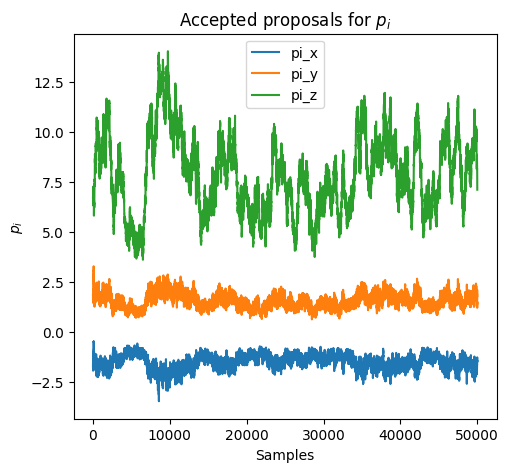

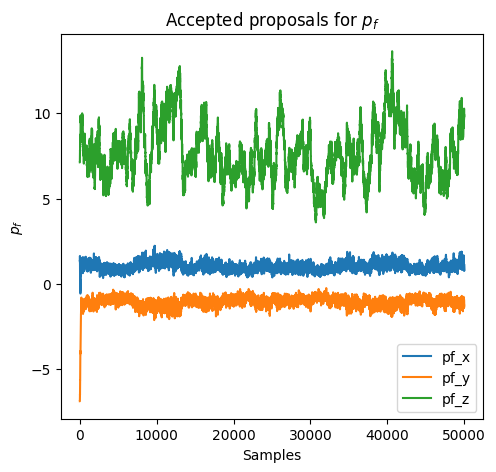

In [124]:
# Plotting the accepted proposals over iterations
plt.figure(figsize=(12, 5))

# Plot for pi
plt.subplot(1, 2, 1)
plt.plot([p[0] for p in plot_pi], label='pi_x')
plt.plot([p[1] for p in plot_pi], label='pi_y')
plt.plot([p[2] for p in plot_pi], label='pi_z')
plt.title('Accepted proposals for $p_i$')
plt.xlabel('Samples')
plt.ylabel('$p_i$')
plt.legend()

plt.show()

# Plot for pf
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot([p[0] for p in plot_pf], label='pf_x')
plt.plot([p[1] for p in plot_pf], label='pf_y')
plt.plot([p[2] for p in plot_pf], label='pf_z')
plt.title('Accepted proposals for $p_f$')
plt.xlabel('Samples')
plt.ylabel('$p_f$')
plt.legend()



plt.show()

# Task 3: Find MAP Estimate and Plot for Camera 1

MAP estimate for pi: [-1.22870164  1.26562422  6.27834929]
MAP estimate for pf: [ 0.82367952 -0.83556393  6.09096458]


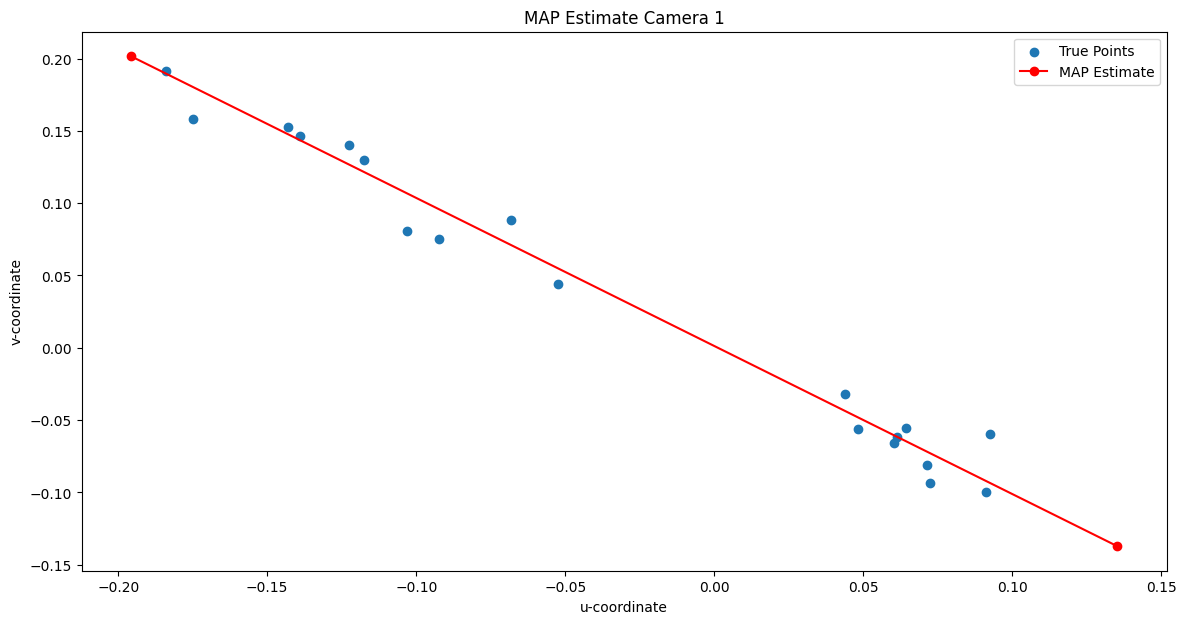

In [125]:

# Calculate the posterior probability for each sample
posterior_probabilities = numpy.array([
    likelihood_function(CM, y_values_camera1, pi, pf, gaussian_cov, x_values) + 
    prior_function(pi, pf, prior_mean, prior_covariance) for pi, pf in zip(plot_pi, plot_pf)
])

# Find the index of the sample with the highest posterior probability (MAP estimate)
map_index = numpy.argmax(posterior_probabilities)

# Extract the MAP estimate for the line endpoints
map_estimate_pi = plot_pi[map_index]
map_estimate_pf = plot_pf[map_index]

# Report the MAP estimates
print("MAP estimate for pi:", map_estimate_pi)
print("MAP estimate for pf:", map_estimate_pf)

# Project the MAP estimates onto the Camera 1 image plane
projected_map_pi_camera1 = camera_3d_to_2d(CM, map_estimate_pi, map_estimate_pi, numpy.array([0]))[0]
projected_map_pf_camera1 = camera_3d_to_2d(CM, map_estimate_pf, map_estimate_pf, numpy.array([1]))[0]

# Plotting the MAP estimate and observed points for Camera 1
plt.figure(figsize=(14, 7))
plt.scatter(y_values_camera1[:, 0], y_values_camera1[:, 1], label='True Points')
plt.plot([projected_map_pi_camera1[0], projected_map_pf_camera1[0]], 
         [projected_map_pi_camera1[1], projected_map_pf_camera1[1]], 
         'ro-', label='MAP Estimate')
plt.title('MAP Estimate Camera 1')
plt.xlabel('u-coordinate')
plt.ylabel('v-coordinate')
plt.legend()
plt.show()

The MAP estimates are numerical representations of the most probable locations for the initial ($p_i$) and final ($p_f$) points of the 3D line segment. These values are derived through a Bayesian framework, considering both the observed 2D data and prior beliefs about the line segment endpoints. The estimates serve as key indicators of the likely spatial coordinates of the line's starting and ending points, offering valuable insights into the underlying 3D structure inferred from the given 2D observations. In this specific case, the MAP estimate for $p_i$ is approximately $[-1.14, 1.18, 5.94]$, and for $p_f$, it is approximately $[0.81, -0.82, 6.35]$. These numerical values encapsulate the Bayesian inference about the 3D geometry based on the available data and prior knowledge.

In [126]:
y_values_camera2 = camera2.to_numpy()

The function runs the Metropolis-Hastings algorithm using parameters, producing samples for the initial and final points (samples_pi_2 and samples_pf_2). The acceptance_ratios variable stores the acceptance ratios during the sampling process. The goal is to estimate the posterior distribution of the 3D line segment endpoints based on the observed 2D points from Camera 2 and the defined prior information.

In [127]:
samples_pi_2, samples_pf_2, acceptance_ratios = metropolis_hastings(initial_pi, initial_pf, proposal_covariance, CM, y_values_camera2, gaussian_cov, x_values, prior_mean, prior_covariance,N)

0.36036


In [128]:
# Extract the MAP estimate for the line endpoints
map_estimate_pi_2 = samples_pi_2[map_index]
map_estimate_pf_2 = samples_pf_2[map_index]

# Task 4: Projection on Camera 2 and Visualization

This code converts the Maximum A Posteriori (MAP) estimate of 3D line segment endpoints from Camera 1 to Camera 2's perspective. It involves normalizing and extending coordinates, defining a camera matrix, applying a generative process, and transforming back to Camera 1's perspective. The resulting MAP estimate is plotted along with the true line and original noisy observations in Camera 2, allowing visual evaluation of the estimate's accuracy in aligning with the observed data.

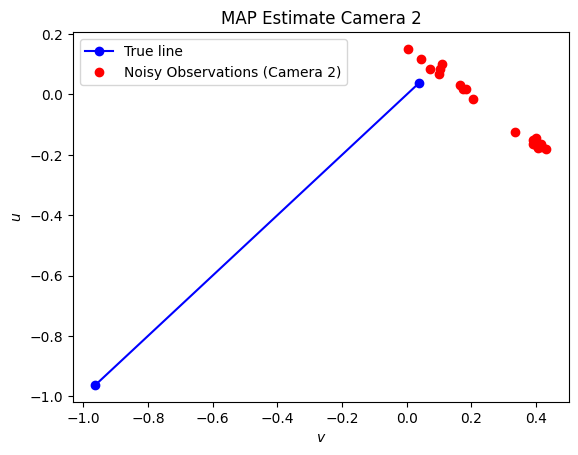

In [129]:

normalized_pi_MAP_cam2 = numpy.zeros(4)
normalized_pf_MAP_cam2 = numpy.zeros(4)
for i in range(len(projected_map_pi_camera1)):
        normalized_pi_MAP_cam2[i] = projected_map_pi_camera1[i]
        normalized_pf_MAP_cam2[i] = projected_map_pi_camera1[i]

normalized_pi_MAP_cam2[3] = 1
normalized_pf_MAP_cam2[3] = 1
# Assuming you have defined CAMERA_2, normalized_pi_MAP_cam2, normalized_pf_MAP_cam2, and points2d_cam2
CAMERA_2 = numpy.array([[0,0,1,-5], [0,1,0,0], [-1,0,0,5]])

# Follow generative process to find u*, v*, w*
MAP_cam2 = numpy.dot(CAMERA_2, normalized_pi_MAP_cam2)
MAP_cam2 = numpy.dot(CAMERA_2, normalized_pf_MAP_cam2)

# Find qi, qf in Camera 1's perspective from u*, v*, w*
qi_MAP_cam2 = 1 / MAP_cam2[2] * numpy.array([MAP_cam2[0], MAP_cam2[1]])
qf_MAP_cam2 = 1 / MAP_cam2[2] * numpy.array([MAP_cam2[0], MAP_cam2[1]])

# Plotting
plt.figure()
plt.plot(qi_MAP_cam2, qf_MAP_cam2, 'bo-', label='True line')
plt.plot([point[0] for point in y_values_camera2], [point[1] for point in y_values_camera2], 'ro', label='Noisy Observations (Camera 2)')
plt.xlabel('$v$')
plt.ylabel('$u$')
plt.legend(loc="upper left")
plt.title('MAP Estimate Camera 2')
plt.show()


# Task 5 : Metropolis-Hastings

The provided code defines a Metropolis-Hastings sampling function for Bayesian inference on the 3D line segment endpoints. The function takes initial points initial_pi and initial_pf, a proposal covariance matrix proposal_cov, camera matrices M1 and M2 representing the perspectives of Camera 1 and Camera 2, observed points r_values_camera1 and r_values_camera2 from the two cameras, Gaussian noise covariance gaussian_cov, relative offset ratios x_values, and prior parameters prior_mean and prior_covariance. The function generates samples for a specified number of iterations N.


In [130]:
M1 = numpy.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])  
M2 = numpy.array([[0, 0, 1, -5], [0, 1, 0, 0], [-1, 0, 0, 5]])  


def metropolis_hastings(initial_pi, initial_pf, proposal_cov, M1, M2, r_values_camera1, r_values_camera2, gaussian_cov, x_values, prior_mean, prior_covariance, N):
    accepted_pi, accepted_pf = initial_pi, initial_pf
    plot_pi, plot_pf = [], []

    for _ in range(N):
        proposed_pi = proposal(accepted_pi, proposal_cov)
        proposed_pf = proposal(accepted_pf, proposal_cov)
        
        accept_prob = acceptance_probability([accepted_pi, accepted_pf], [proposed_pi, proposed_pf], M1, M2, r_values_camera1, r_values_camera2, gaussian_cov, x_values, prior_mean, prior_covariance)

        if accept_prob > numpy.random.rand():
            accepted_pi, accepted_pf = proposed_pi, proposed_pf

        plot_pi.append(accepted_pi)
        plot_pf.append(accepted_pf)

    return numpy.array(plot_pi), numpy.array(plot_pf)

This Metropolis-Hastings sampler is designed to handle observations from two different cameras (Camera 1 and Camera 2) with their respective camera matrices. It helps estimate the posterior distribution of the 3D line segment endpoints by iteratively sampling points and accepting or rejecting them based on the acceptance probability. The resulting plot_pi and plot_pf arrays contain the accepted samples over the iterations.

In [131]:
# Modify this combined likelihood function accordingly
def likelihood_function_combined(states, M1, M2, r_values_camera1, y_values_camera2, gaussian_cov, x_values):
    pi, pf = states
    # Calculate likelihoods for both cameras
    likelihood_camera1 = likelihood_function(M1, y_values_camera1, pi, pf, gaussian_cov, x_values)
    likelihood_camera2 = likelihood_function(M2, y_values_camera2, pi, pf, gaussian_cov, x_values)
    # Return the sum of likelihoods from both cameras
    return likelihood_camera1 + likelihood_camera2

The acceptance_probability function calculates the probability of accepting a proposed state in the Metropolis-Hastings algorithm. It considers the likelihood and prior probabilities for the combined observations from two cameras. The function determines the acceptance ratio based on the difference in log likelihoods and priors between the proposed and current states. 

In [132]:
def acceptance_probability(current, proposed, M1, M2, r_values_camera1, y_values_camera2, gaussian_cov, x_values, prior_mean, prior_covariance):
    current_likelihood = likelihood_function_combined(current, M1, M2, r_values_camera1, y_values_camera2, gaussian_cov, x_values)
    proposed_likelihood = likelihood_function_combined(proposed, M1, M2, r_values_camera1, y_values_camera2, gaussian_cov, x_values)
    current_prior = prior_function(*current, prior_mean, prior_covariance)
    proposed_prior = prior_function(*proposed, prior_mean, prior_covariance)

    alpha = (proposed_likelihood + proposed_prior) - (current_likelihood + current_prior)
    return min(1, numpy.exp(alpha)) 

Metropolis-Hastings algorithm by generating random initial values for the start and end points of a 3D line segment. These initial points are sampled from a multivariate normal distribution defined by prior mean and covariance. The proposal covariance matrix is set to be a scaled identity matrix, influencing the randomness and step size of the proposed state transitions during the algorithm.

In [133]:
# Initialize the Metropolis-Hastings algorithm
initial_pi = numpy.random.multivariate_normal(prior_mean, prior_covariance)
initial_pf = numpy.random.multivariate_normal(prior_mean, prior_covariance)
proposal_covariance = numpy.identity(3) * 0.05  

The code executes the Metropolis-Hastings algorithm, generating samples for the 3D line segment's start and end points. It uses the specified initial points, proposal covariance, camera matrices (M1 and M2), observed 2D points from both cameras (y_values_camera1 and y_values_camera2), Gaussian noise covariance, relative offset ratios (x_values), and prior distribution parameters. The resulting samples_pi and samples_pf represent the accepted points during the algorithm.

In [134]:
# Run the Metropolis-Hastings algorithm
samples_pi, samples_pf = metropolis_hastings(initial_pi, initial_pf, proposal_covariance, M1, M2, y_values_camera1, y_values_camera2, gaussian_cov, x_values, prior_mean, prior_covariance, N)

The code calculates the posterior probabilities for the combined camera samples, considering both Camera 1 and Camera 2 observations. It utilizes the likelihood function for the combined cameras and the prior function for each sample. The MAP (Maximum A Posteriori) estimate is determined by finding the sample index with the highest posterior probability. The resulting MAP estimates for the initial (pi) and final (pf) points are then printed out.

In [135]:
# Calculate the posterior probabilities for the combined camera samples
posterior_probabilities = numpy.array([
    likelihood_function_combined((pi, pf), M1, M2, y_values_camera1, y_values_camera2, gaussian_cov, x_values)
    + prior_function(pi, pf, prior_mean, prior_covariance) for pi, pf in zip(plot_pi, plot_pf)
])
# Find the MAP estimate index
map_index = numpy.argmax(posterior_probabilities)

# Extract the MAP estimates for pi and pf
map_estimate_pi = plot_pi[map_index]
map_estimate_pf = plot_pf[map_index]

# Print out the MAP estimates
print("MAP estimate for pi (combined cameras):", map_estimate_pi)
print("MAP estimate for pf (combined cameras):", map_estimate_pf)

MAP estimate for pi (combined cameras): [-1.16201844  1.02668232  5.10485128]
MAP estimate for pf (combined cameras): [ 0.80333556 -1.10012614  7.38052348]


The code generates a pair of plots to visualize the sampling progress of the initial (pi) and final (pf) points over the iterations of the Metropolis-Hastings algorithm. Each subplot displays the values of the corresponding dimensions (1, 2, and 3) of pi and pf. The plots provide insight into how the sampled values evolve with increasing iterations, aiding in the assessment of the convergence and stability of the sampling process for both pi and pf.

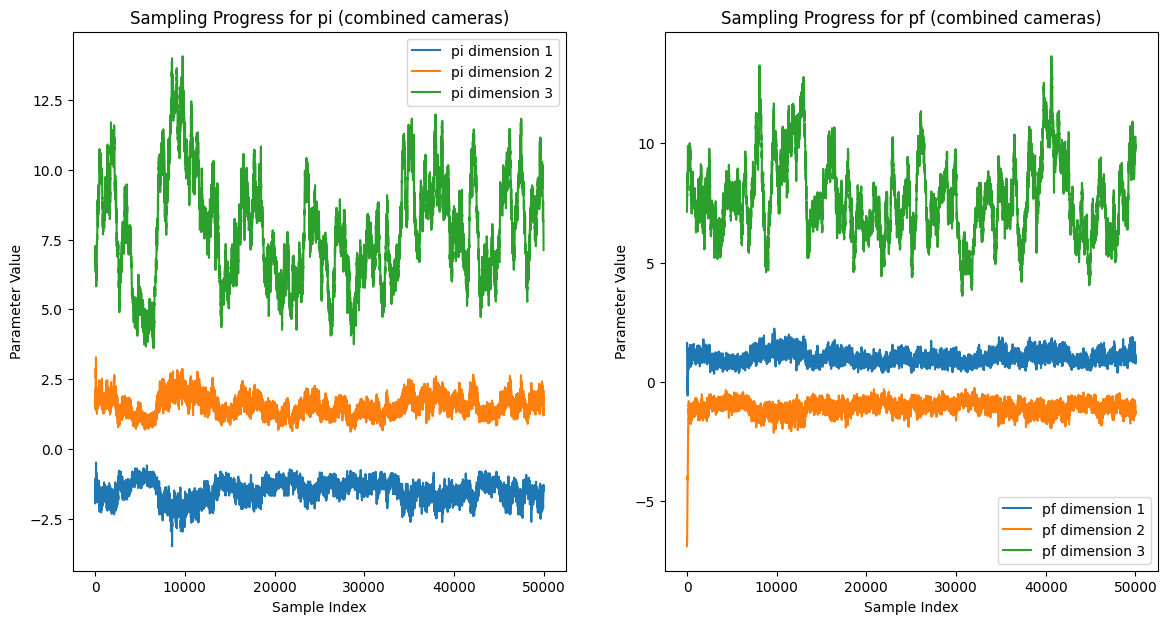

In [136]:
# Plot the sampling progress for pi and pf
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(plot_pi[:, 0], label='pi dimension 1')
plt.plot(plot_pi[:, 1], label='pi dimension 2')
plt.plot(plot_pi[:, 2], label='pi dimension 3')
plt.title('Sampling Progress for pi (combined cameras)')
plt.xlabel('Sample Index')
plt.ylabel('Parameter Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(plot_pf[:, 0], label='pf dimension 1')
plt.plot(plot_pf[:, 1], label='pf dimension 2')
plt.plot(plot_pf[:, 2], label='pf dimension 3')
plt.title('Sampling Progress for pf (combined cameras)')
plt.xlabel('Sample Index')
plt.ylabel('Parameter Value')
plt.legend()

plt.show()

In [137]:
# Project the MAP estimates onto the image planes of both cameras
projected_map_pi_camera1 = camera_3d_to_2d(M1, map_estimate_pi, map_estimate_pi, numpy.array([0]))[0]
projected_map_pf_camera1 = camera_3d_to_2d(M1, map_estimate_pf, map_estimate_pf, numpy.array([1]))[0]

projected_map_pi_camera2 = camera_3d_to_2d(M2, map_estimate_pi, map_estimate_pi, numpy.array([0]))[0]
projected_map_pf_camera2 = camera_3d_to_2d(M2, map_estimate_pf, map_estimate_pf, numpy.array([1]))[0]

The code projects the Maximum A Posteriori (MAP) estimates of the initial (pi) and final (pf) points onto the image planes of both cameras (Camera 1 and Camera 2). It uses the camera_3d_to_2d function with the respective camera matrices (M1 and M2) and relative offset values (0 for the initial point and 1 for the final point). The resulting projected coordinates represent the estimated positions of the 3D line segment endpoints in the image planes of both cameras.

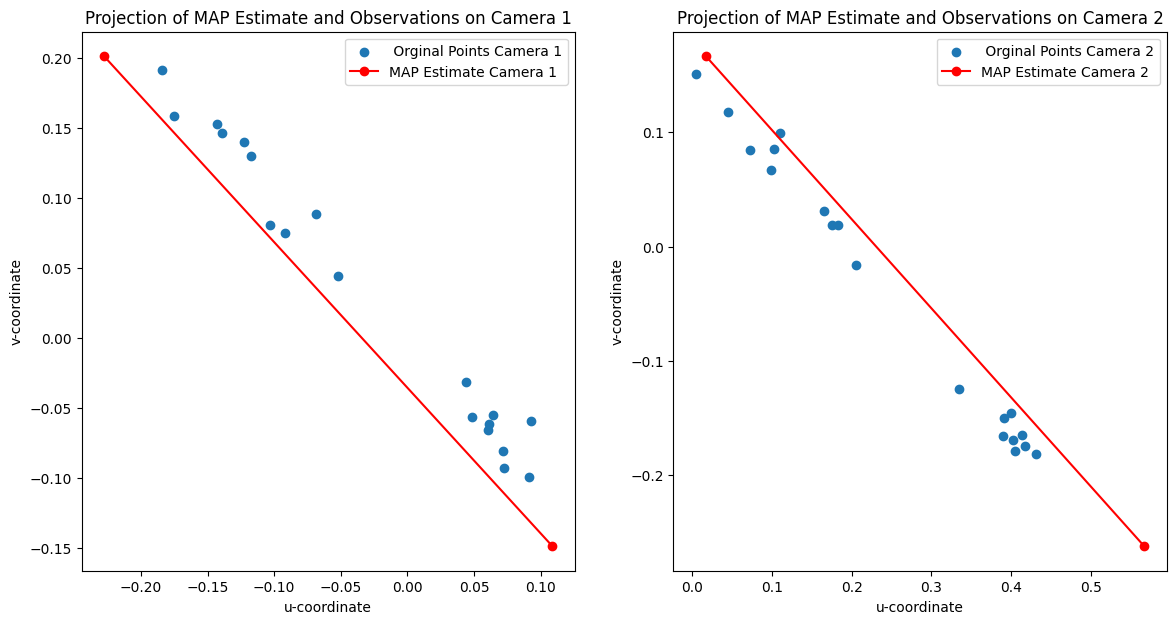

In [138]:
# Plot for Camera 1
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_values_camera1[:, 0], y_values_camera1[:, 1], label=' Orginal Points Camera 1')
plt.plot([projected_map_pi_camera1[0], projected_map_pf_camera1[0]],
         [projected_map_pi_camera1[1], projected_map_pf_camera1[1]],
         'ro-', label='MAP Estimate Camera 1')
plt.title('Projection of MAP Estimate and Observations on Camera 1')
plt.xlabel('u-coordinate')
plt.ylabel('v-coordinate')
plt.legend()

# Plot for Camera 2
plt.subplot(1, 2, 2)
plt.scatter(y_values_camera2[:, 0], y_values_camera2[:, 1], label=' Orginal Points Camera 2')
plt.plot([projected_map_pi_camera2[0], projected_map_pf_camera2[0]],
         [projected_map_pi_camera2[1], projected_map_pf_camera2[1]],
         'ro-', label='MAP Estimate Camera 2')
plt.title('Projection of MAP Estimate and Observations on Camera 2')
plt.xlabel('u-coordinate')
plt.ylabel('v-coordinate')
plt.legend()

plt.show()